# Forecasting by LSTM

This script prepares individual records from merged_driver_and_ping_data.csv for LSTM. Each record is split into sequences. A single layer LSTM model is built and compared against a single layer LSTM with auxillary inputsThe model are built using Keras with tensorflow backend. Two models are built for comparison. The model will use a 7 day window to capture weekly patterns which can be modified.

**Inputs:**       
1. *merged_driver_and_ping_data.csv*
              
**Outputs:**     
1. *Base model:* treat all individuals as belonging to the same group
1. *Base with auxilliary input:* include auxillary input (age, gender, kids)

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas as pd
import os
import datetime
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense, LSTM, concatenate
from keras.optimizers import SGD, Adam
from sklearn.preprocessing import StandardScaler
import pandas as pd

Using TensorFlow backend.


In [3]:
# data prep helper functions
def read_csv(path, sep=",", sortby=[]):
    '''
    read csv files
    '''
    # load data
    data = pd.read_csv(path, sep=sep)
    
    # sort and reindex
    if len(sortby) != 0:
        data = data.sort_values(sortby, ascending=False)
        data = data.reset_index(drop=True)

    print("Data loading & sorting completed")
    print("Total Observation: ", data.shape[0])
    return data

In [4]:
# Define data preparation parameters
window = 8

In [5]:
# define file parameters
CWD = os.getcwd()
DATA = CWD + "\\data\\sequence_merged_driver_and_ping_data.csv"

In [6]:
# load and check csv
transformed_data = read_csv(DATA)
transformed_data = transformed_data.rename({'Unnamed: 0':'driver_id'}, axis=1)
transformed_data = transformed_data.set_index(['driver_id'])

transformed_data[0:5]

Data loading & sorting completed
Total Observation:  34762


,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,age,number_of_kids,isMALE
driver_id,,,,,,,,,,,
111556,2.0,2.0,0.0,0.0,4.0,2.0,2.0,3.0,49.0,4.0,0.0
111556,2.0,0.0,0.0,4.0,2.0,2.0,3.0,4.0,49.0,4.0,0.0
111556,0.0,0.0,4.0,2.0,2.0,3.0,4.0,0.0,49.0,4.0,0.0
111556,0.0,4.0,2.0,2.0,3.0,4.0,0.0,0.0,49.0,4.0,0.0
111556,4.0,2.0,2.0,3.0,4.0,0.0,0.0,3.0,49.0,4.0,0.0


### Model Build Functions

In [7]:
# model helper functions
def split_train_test(data, ratio, window):
    '''
    split data by train and test
    '''
    sample = data.values
    n_split = int(ratio*sample.shape[0])

    sample_train = sample[:n_split, :]
    sample_test = sample[n_split:, :]

    train = sample_train[:,0:window-1]
    train_y = sample_train[:,window-1:window]

    test = sample_test[:,0:window-1]
    test_y = sample_test[:,window-1:window]

    # reshape input to be 3D [samples, timesteps, features]
    train = train.reshape((train.shape[0], 1, train.shape[1]))
    test = test.reshape((test.shape[0], 1, test.shape[1]))
    
    print(train.shape, train_y.shape, test.shape, test_y.shape)
    
    return train, train_y, test, test_y, n_split

def eval_rmse(target, pred):
    '''
    RMSE for models
    '''
    rmse = sqrt(mean_squared_error(target, pred))
    print('Test RMSE: %.3f' % rmse)
    return rmse


def build_model_1(batch_size, time_steps, features):
    '''
    LSTM model architecture
    '''
    # specify architecture
    model = Sequential()
    model.add(LSTM(20, batch_input_shape=(batch_size, time_steps, features), return_sequences=True))

    model.add(Dense(num_classes))
    model.add(Activation('linear'))

    # Specify optimization function
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=adam , metrics=['accuracy'])
    return model
  
    
def build_model_base(neurons, timestep, features):
    '''
    LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting hours.
    The input shape will be 1 time step with 6 features. Output 1 since this is a regression problem.
    '''
    # specify architecture
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(timestep, features)))
    model.add(Dense(1))
    
    # Specify optimization function and compile model
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='mae', optimizer=adam)
    
    return model

def build_model_with_aux(neurons, timestep, features, aux_features):
    '''
    Add auxiliary input - auxiliary inputs contains 3 features
    create Dense branch on the comparison features
    '''
    # specify architecture
    temporal_input = Input(shape=(timestep, features), name='temporal_input')
    lstm_out = LSTM(neurons)
    lstm_out = lstm_out(temporal_input)

    auxiliary_input = Input(shape=(aux_features,), name='auxillary_input')

    main_input = concatenate([lstm_out, auxiliary_input])
    main = Dense(64, activation='relu')(main_input)
    main = Dense(32, activation='relu')(main)

    # add the main output layer
    main_output = Dense(1, name='main_output')(main)
    
    model = Model(inputs=[temporal_input, auxiliary_input], outputs=main_output)

    # Specify optimization function and compile model
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='mae', optimizer=adam)
    
    return model

def predict_model(test, test_y, yhat):
    '''
    predict on test data
    '''
    test = test.reshape((test.shape[0], test.shape[2]))
    
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test[:, 1:]), axis=1)
    #inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test[:, 1:]), axis=1)
    #inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    return inv_y, inv_yhat

def predict_model_aux(test_temporal, test_aux, test_y, yhat):
    '''
    predict on test data
    '''
    test_temporal = test_temporal.reshape((test_temporal.shape[0], test_temporal.shape[2]))
    
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_temporal[:, 1:], test_aux[:, test_temporal.shape[1]+1:]), axis=1)
    #inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

    # invert scaling for actual
    # test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_temporal[:, 1:], test_aux[:, test_temporal.shape[1]+1:]), axis=1)
    #inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    return inv_y, inv_yhat

In [8]:
# Save training graphs and model files in desired folders
archive_dir = CWD + '\\model\\'

id = str(datetime.datetime.now())
id = id.replace(':', '_')
id = id.replace(' ', '_t_')

todayDate = datetime.datetime.today().strftime('%Y-%m-%d')

runNo = len(np.unique([name.split(".")[0].split("_")[0] for name in os.listdir(archive_dir) if os.path.isfile(archive_dir+name)]))+1
# runNo = len([name for name in os.listdir(archive_dir) if os.path.isfile(archive_dir+name)])+1

## LSTM Model

This model will serve as the base model for comparison with the auxillary input model. Only the time series elements are used. For simplicity a single LSTM layer is used. This can be easily extended into a stacked LSTM by adding more LSTM layers in build_model_base() through the following means. 

    # specify architecture 
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(timestep, features)), return_sequences=True)
    model.add(LSTM(neurons, return_sequences=True)
    model.add(LSTM(neurons)
    model.add(Dense(1))

In [9]:
# split into train and test sets
transformed_data_temporal = transformed_data.drop(["age", "number_of_kids", "isMALE"], axis=1)
train, train_y, test, test_y, n_split = split_train_test(transformed_data_temporal, 0.7, window)

(24333, 1, 7) (24333, 1) (10429, 1, 7) (10429, 1)


In [10]:
# define lstm model parameters
epoch = 100
neurons = 50
batchsize = 14*5 # each individual has 14 sequences 
timestep = train.shape[1]
features = train.shape[2]

# load model
model = build_model_base(neurons, timestep, features)
model.summary()

# fit network
model.fit(train, train_y, epochs=epoch, batch_size=batchsize, validation_data=(test, test_y), verbose=2, shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,651
Trainable params: 11,651
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 24333 samples, validate on 10429 samples
Epoch 1/100
 - 4s - loss: 1.6103 - val_loss: 1.3267
Epoch 2/100
 - 2s - loss: 1.3017 - val_loss: 1.3126
Epoch 3/100
 - 2s - loss: 1.2880 - val_loss: 1.2978
Epoch 4/100
 - 2s - loss: 1.2789 - val_loss: 1.2952
Epoch 5/100
 - 2s - loss: 1.2694 - val_loss: 1.2881
Epoch 6/100
 - 2s - loss: 1.2598 - val_loss: 1.2866
Epoch 7/100
 - 2s - loss: 1.2514 - val_loss: 1.2759


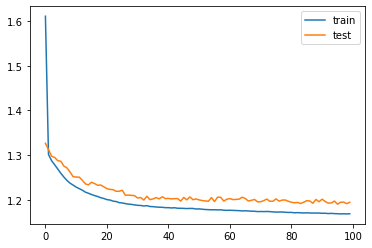

In [11]:
# plot training and validation loss
plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [12]:
# predict
yhat = model.predict(test)
inv_y, inv_yhat = predict_model(test, test_y, yhat)

# calculate RMSE
rmse = eval_rmse(inv_y, inv_yhat)

Test RMSE: 1.737


In [13]:
# Save weights after training
model.save_weights(archive_dir+'run'+str(runNo)+'_'+todayDate+'model_weights.h5')
model.save(archive_dir+'run'+str(runNo)+'_'+todayDate+'model.h5')

In [14]:
# visualise
print(np.round(inv_yhat[0:5],1))

print(inv_y[0:5])

[7.  7.  6.7 6.8 7. ]
[8. 5. 8. 8. 5.]


## LSTM Model with Auxillary Inputs

Conceptually, the following approach is taken to add auxillary data into the model. 

TIME_SERIES_INPUT ------> LSTM -------\

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;---> MERGE ---> [more processing]

AUXILIARY_INPUTS --> [do something] --/

In [15]:
# Prepare auxillary data
transformed_data_aux = transformed_data[["age", "number_of_kids", "isMALE"]]

transformed_data_temporal_pred = transformed_data_temporal[['day_7']]
transformed_data_temporal_pred_train = transformed_data_temporal_pred[:n_split]
transformed_data_temporal_pred_test = transformed_data_temporal_pred[n_split:]

# reshape input to be 3D [samples, timesteps, features]
transformed_data_temporal = transformed_data_temporal.drop(['day_7'], axis=1)
transformed_data_temporal_val = transformed_data_temporal.values
transformed_data_temporal_pred = transformed_data_temporal_pred.values

transformed_data_temporal = transformed_data_temporal_val.reshape((transformed_data_temporal.shape[0], 1, transformed_data_temporal.shape[1]))
transformed_data_temporal_train = transformed_data_temporal[:n_split, :, :]
transformed_data_temporal_test = transformed_data_temporal[n_split:, :, :]

transformed_data_aux_val = transformed_data_aux.values
transformed_data_aux = transformed_data_aux_val.reshape((transformed_data_aux_val.shape[0], transformed_data_aux_val.shape[1]))
transformed_data_aux_train = transformed_data_aux[:n_split, :]
transformed_data_aux_test = transformed_data_aux[n_split:, :]

print("TRAIN: ", transformed_data_temporal_train.shape, transformed_data_aux_train.shape, transformed_data_temporal_pred_train.shape)
print("TEST: ", transformed_data_temporal_test.shape, transformed_data_aux_test.shape, transformed_data_temporal_pred_test.shape)

TRAIN:  (24333, 1, 7) (24333, 3) (24333, 1)
TEST:  (10429, 1, 7) (10429, 3) (10429, 1)


In [16]:
# define auxillary parameters - number of available features on each measurement
aux_features = 3 

In [17]:
# load model
model_aux = build_model_with_aux(neurons, timestep, features, aux_features)
model_aux.summary()

# fit network
# model_aux.fit({'temporal_input':transformed_data_temporal, 'auxillary_input':transformed_data_aux}, 
#               {'main_output':transformed_data_temporal_pred}, epochs=epoch, batch_size=72,
#               validation_split=0.1, verbose=2, shuffle=False)

model_aux.fit({'temporal_input':transformed_data_temporal_train, 'auxillary_input':transformed_data_aux_train}, 
              {'main_output':transformed_data_temporal_pred_train},
              epochs=epoch, batch_size=batchsize,
              validation_data=({'temporal_input':transformed_data_temporal_test, 'auxillary_input':transformed_data_aux_test},
                               {'main_output':transformed_data_temporal_pred_test}),
              verbose=2, shuffle=False)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
temporal_input (InputLayer)     (None, 1, 7)         0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 50)           11600       temporal_input[0][0]             
__________________________________________________________________________________________________
auxillary_input (InputLayer)    (None, 3)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 53)           0           lstm_2[0][0]                     
                                                                 auxillary_input[0][0]            
__________

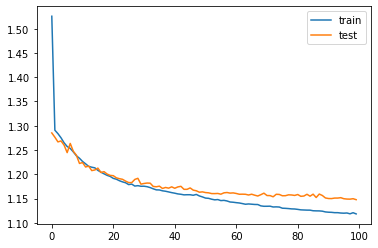

In [18]:
# plot training and validation loss
plt.plot(model_aux.history.history['loss'], label='train')
plt.plot(model_aux.history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [19]:
# predict
yhat = model_aux.predict({'temporal_input':transformed_data_temporal_test, 'auxillary_input':transformed_data_aux_test})
inv_y, inv_yhat = predict_model_aux(transformed_data_temporal_test, transformed_data_aux_test,
                                    transformed_data_temporal_pred_test, yhat)

# calculate RMSE
rmse = eval_rmse(inv_y, inv_yhat)

Test RMSE: 1.707


In [20]:
# Save weights after training
model_aux.save_weights(archive_dir+'run'+str(runNo)+'_'+todayDate+'model_aux_weights.h5')
model_aux.save(archive_dir+'run'+str(runNo)+'_'+todayDate+'model_aux.h5')